In [7]:
!pip3 install yfinance
import yfinance as yf

In [6]:
sp500 = yf.Ticker("^GSPC")

In [8]:
sp500 = sp500.history(period = "max")

In [9]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-31 00:00:00-04:00,5243.209961,5280.330078,5191.680176,5277.509766,5437160000,0.0,0.0
2024-06-03 00:00:00-04:00,5297.149902,5302.109863,5234.319824,5283.399902,4046920000,0.0,0.0
2024-06-04 00:00:00-04:00,5278.240234,5298.799805,5257.629883,5291.339844,3707900000,0.0,0.0


In [10]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2024-05-23 00:00:00-04:00', '2024-05-24 00:00:00-04:00',
               '2024-05-28 00:00:00-04:00', '2024-05-29 00:00:00-04:00',
               '2024-05-30 00:00:00-04:00', '2024-05-31 00:00:00-04:00',
               '2024-06-03 00:00:00-04:00', '2024-06-04 00:00:00-04:00',
               '2024-06-05 00:00:00-04:00', '2024-06-06 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24224, freq=None)

<Axes: xlabel='Date'>

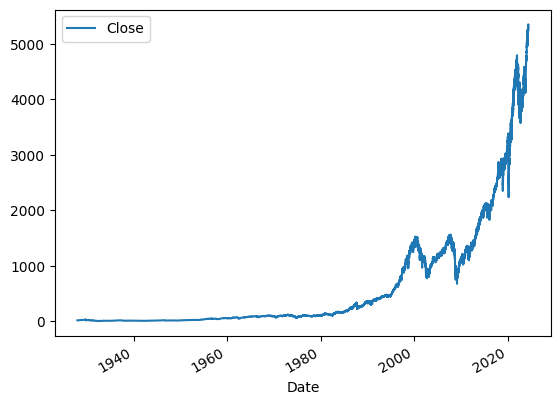

In [11]:
sp500.plot.line(y="Close", use_index=True)

In [12]:
del sp500["Dividends"] 
del sp500["Stock Splits"]

In [14]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [18]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [20]:
sp500 = sp500.loc["1990-01-01":].copy()

In [27]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [40]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.0

In [36]:
combined = pd.concat([test["Target"], preds], axis=1)

<Axes: xlabel='Date'>

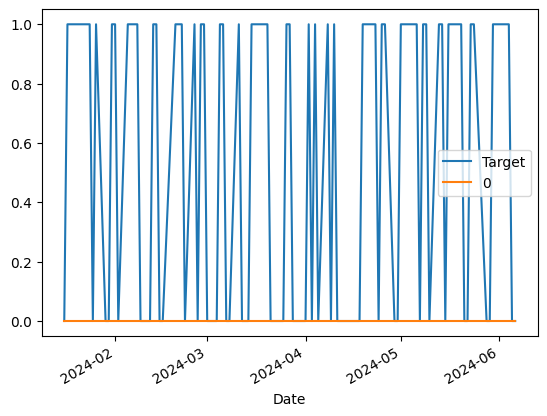

In [37]:
combined.plot()

In [46]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

In [47]:
def backtest(data, model, predictors, start = 2500, step = 250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [48]:
predictions = backtest(sp500, model, predictors)

In [50]:
predictions["Predictions"].value_counts()

Predictions
0    3572
1    2602
Name: count, dtype: int64

In [52]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5292083013066872

In [53]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.534823
0    0.465177
Name: count, dtype: float64

In [56]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ration_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]

In [58]:
sp500 = sp500.dropna()

In [59]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ration_2,Close_Ration_5,Close_Ration_60,Close_Ration_250,Close_Ration_1000,Trend_2,Trend_5,Trend_60,Trend_250,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,0.996617,1.000283,1.028047,1.176082,1.0,1.0,32.0,127.0,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.995899,0.997329,1.025151,1.172676,0.0,1.0,32.0,126.0,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,0.999495,1.000311,1.028274,1.176163,1.0,2.0,32.0,127.0,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,1.004991,1.006561,1.034781,1.183537,2.0,3.0,32.0,128.0,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.003784,1.005120,1.033359,1.181856,1.0,2.0,32.0,128.0,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30 00:00:00-04:00,5259.770020,5260.209961,5222.100098,5235.479980,3818750000,5277.509766,1,0.997004,0.992281,1.011892,1.112889,1.249600,0.0,2.0,31.0,139.0,529.0
2024-05-31 00:00:00-04:00,5243.209961,5280.330078,5191.680176,5277.509766,5437160000,5283.399902,1,1.003998,0.999881,1.019448,1.120875,1.259004,1.0,3.0,31.0,139.0,530.0
2024-06-03 00:00:00-04:00,5297.149902,5302.109863,5234.319824,5283.399902,4046920000,5291.339844,1,1.000558,1.001806,1.020172,1.121164,1.259724,2.0,3.0,31.0,140.0,531.0


In [60]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [61]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds>= .6] = 1
    preds [preds < .6] = 0
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

In [62]:
predictions = backtest(sp500, model, new_predictors)

In [63]:
predictions["Predictions"].value_counts()

Predictions
0.0    4340
1.0     833
Name: count, dtype: int64

In [65]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5738295318127251

In [66]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.544558
0    0.455442
Name: count, dtype: float64

In [67]:
predictions


,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,1.0
2003-11-18 00:00:00-05:00,1,1.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,1,1.0
...,...,...
2024-05-30 00:00:00-04:00,1,0.0
2024-05-31 00:00:00-04:00,1,0.0
2024-06-03 00:00:00-04:00,1,0.0
